## Calculate PERMANOVA Adonis R<sup>2</sup>  from Qiime2 distance matrices

In [2]:
# These commands do not work on Windows. Until we have found a way to do it automatically, 
# you should unzip the distance_matrix.qza manually in the newly (manually) created folders 
# and move the subfolder up one folder.


#system('unzip -d MultStats/Canberra/ MultStats/canberra_distance_matrix.qza')
#system('unzip7z -d MultStats/BrayCurtis/ /MultStats/bray_distance_matrix.qza')
#system('unzip7z -d MultStats/Jaccard/ /MultStats/jaccard_distance_matrix.qza')
#system('unzip -d /Deicode/ deicode_distance_matrix.qza')

Warning message:
"running command '7z -d MultStats/Canberra/ MultStats/canberra_distance_matrix.qza' had status 127"Warning message:
"running command '7z -d MultStats/BrayCurtis/ /MultStats/bray_distance_matrix.qza' had status 127"Warning message:
"running command '7z -d MultStats/Jaccard/ /MultStats/jaccard_distance_matrix.qza' had status 127"

load libraries

In [1]:
library(vegan)
library(ggplot2)


Warning message:
"package 'vegan' was built under R version 3.6.3"
Loading required package: permute

Warning message:
"package 'permute' was built under R version 3.6.3"
Loading required package: lattice

This is vegan 2.5-6

Warning message:
"package 'ggplot2' was built under R version 3.6.3"


load distance matrices

In [2]:
dis_bray <- read.table(paste(list.dirs(path = "BrayCurtis/")[3],list.files(list.dirs(path = "BrayCurtis/")[3]),sep="/"),sep = "\t",header=T, row.names = 1)
dis_canberra <- read.table(paste(list.dirs(path = "Canberra/")[3],list.files(list.dirs(path = "Canberra/")[3]),sep="/"),sep = "\t",header=T, row.names = 1)
dis_jaccard <- read.table(paste(list.dirs(path = "Jaccard/")[3],list.files(list.dirs(path = "Jaccard/")[3]),sep="/"),sep = "\t",header=T, row.names = 1)
dis_deicode <- read.table(paste(list.dirs(path = "Deicode/")[3],list.files(list.dirs(path = "Deicode/")[3]),sep="/"),sep = "\t",header=T, row.names = 1)

load metadata

In [3]:
# needs to be the metadata table generated during qiime2 processing
md <- read.csv('Metadata_Qiime2.tsv', sep = '\t', stringsAsFactors = F)

In [4]:
distances <- list(dis_bray,dis_canberra,dis_jaccard,dis_deicode) 
names(distances) <- c("braycurtis","canberra","jaccard", "deicode") 

# bring all rows and columns of distance matrices in same order
for (i in 1:length(distances)){
  distances[[i]] <- distances[[i]][match(rownames(distances[[1]]),rownames(distances[[i]])),]
  distances[[i]] <- distances[[i]][,match(colnames(distances[[1]]),colnames(distances[[i]]))]
}

In [5]:
all(sapply(rownames(distances), FUN = identical, dis_bray)) # should be TRUE

[1] TRUE

In [7]:
metadata <- md
rownames(metadata) <- md$X.SampleID
metadata <- metadata[which(rownames(metadata)%in%rownames(distances[[1]])),]
metadata <- metadata[match(rownames(distances[[1]]),rownames(metadata)),]

In [9]:
dim(distances[[1]])
dim(metadata)

[1] 68 68

[1] 68 43

select only metadata categories with at least 2 subcategories

In [10]:
s <- c()
coln <- colnames(metadata)
for (i in 1:length(coln)){
  t <- length(unique(metadata[,colnames(metadata)== coln[i]]))
  s <- c(s,t)
}

In [11]:
cats <- sort(coln[which(s > 1)]) 

calculate Adonis R<sup>2</sup> 

In [17]:
Rsq <- c()
pval <- c()
for (i in 1:length(cats)){
  for (j in 1:length(distances)){
    if (length(which(is.na(metadata[,colnames(metadata) == cats[i]]))) !=0){
      red <- as.dist(distances[[j]][-which(is.na(metadata[,colnames(metadata) == cats[i]])),-which(is.na(metadata[,colnames(metadata) == cats[i]]))])
      Rsq <- c(Rsq,adonis(red ~ na.omit(metadata[,colnames(metadata) == cats[i]]))$aov.tab$R2[1])
      pval <- c(pval,adonis(red ~ na.omit(metadata[,colnames(metadata) == cats[i]]))$aov.tab$'Pr(>F)'[1])
    } else {
      Rsq <- c(Rsq,adonis(as.dist(distances[[j]]) ~ metadata[,colnames(metadata) == cats[i]])$aov.tab$R2[1])
      pval <- c(pval,adonis(as.dist(distances[[j]]) ~ metadata[,colnames(metadata) == cats[i]])$aov.tab$'Pr(>F)'[1])
    }
  }
}

create output matrix

In [18]:
out <- matrix(0, length(cats)*length(distances),4)
out[,1] <- rep(cats,each=length(distances))  
out[,2] <- rep(names(distances),length(cat))
out[,3] <- Rsq
out[,4] <- pval

colnames(out) <- c("metadata","metric","AdonisR2","pvalue")
out <- as.data.frame(out)
out$AdonisR2 <- as.numeric(as.character(out$AdonisR2))
out$pvalue <- as.numeric(as.character(out$pvalue))

# perform FDR correction within groups
out$pvalue_corr <- out$pvalue
for (i in 1:length(cats)){
  out$pvalue_corr[which(out$metadata==cats[i])]  <- p.adjust(out$pvalue_corr[which(out$metadata==cats[i])],method = "fdr")
}

out$sig <- out$pvalue_corr
out$sig[out$sig>0.05] <- "p>0.05"
out$sig[out$sig<0.05] <- "p<0.05"
out$sig <- as.factor(out$sig)

visualize results

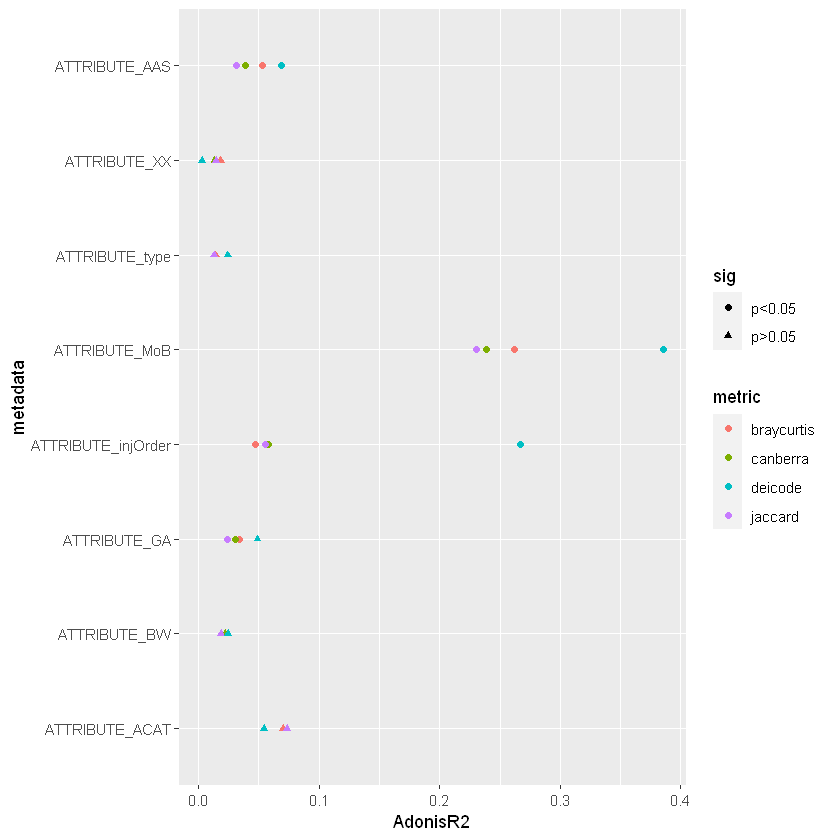

In [21]:
ggplot(out, aes(AdonisR2, metadata)) +
  geom_point(aes(color = metric, shape = sig)) 

In [27]:
pdf(file="AdonisR2.pdf", width=6, height=3)
ggplot(out, aes(AdonisR2, metadata)) +
  geom_point(aes(color = metric, shape = sig)) #alpha = "0.3"
dev.off()

png 
  2

In [28]:
write.table(out,'AdonisR2.txt',sep = '\t', row.names = F, quote = F)

In [29]:
out$stars <- as.character(out$sig)

In [30]:
out$stars[which(out$stars == 'p>0.05')] <- ''
out$stars[which(out$stars == 'p<0.05')] <- '*'

In [31]:
out$metadata <- gsub('ATTRIBUTE_','',out$metadata)

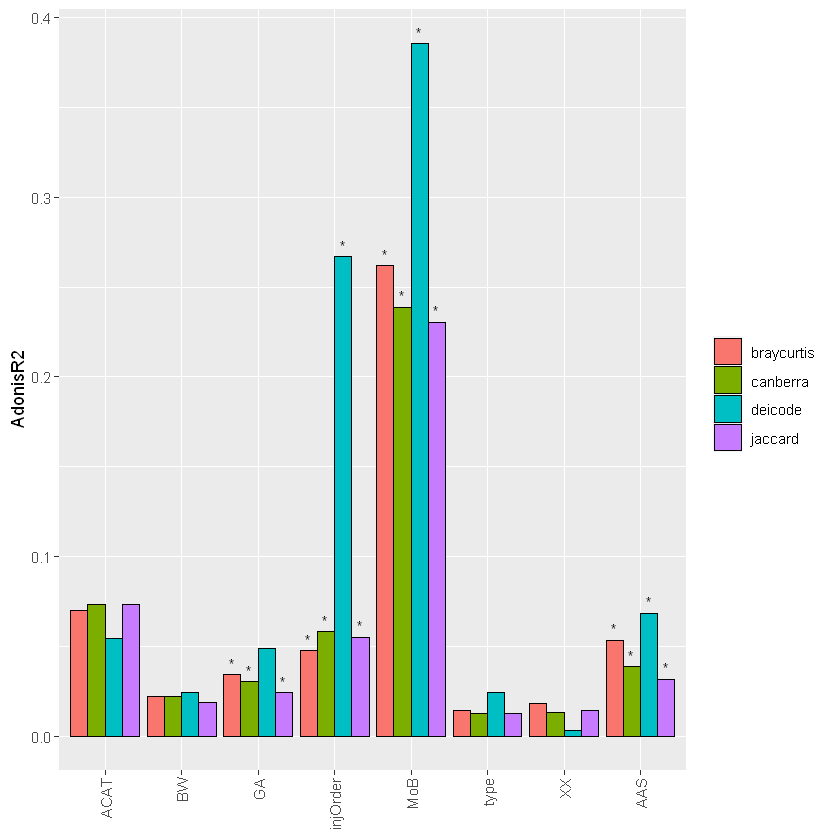

In [33]:
ggplot(out, aes(x=metadata, y=AdonisR2, fill=metric)) + 
geom_bar(colour="black", stat="identity", position='dodge') +
geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
ggpubr::rotate_x_text() +
theme(axis.title.x=element_blank(), legend.title = element_blank())

In [34]:
pdf(file="AdonisR2_BARS.pdf", width=6, height=6)
    ggplot(out, aes(x=metadata, y=AdonisR2, fill=metric)) + 
    geom_bar(colour="black", stat="identity", position='dodge') +
    geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
    ggpubr::rotate_x_text() +
    labs(y= "Adonis R2") +
    theme(axis.title.x=element_blank(), legend.title = element_blank())
dev.off()

png 
  2

In [41]:
cbPalette <- c("#009999", "#66CC99", "#99CCFF", "#006699")

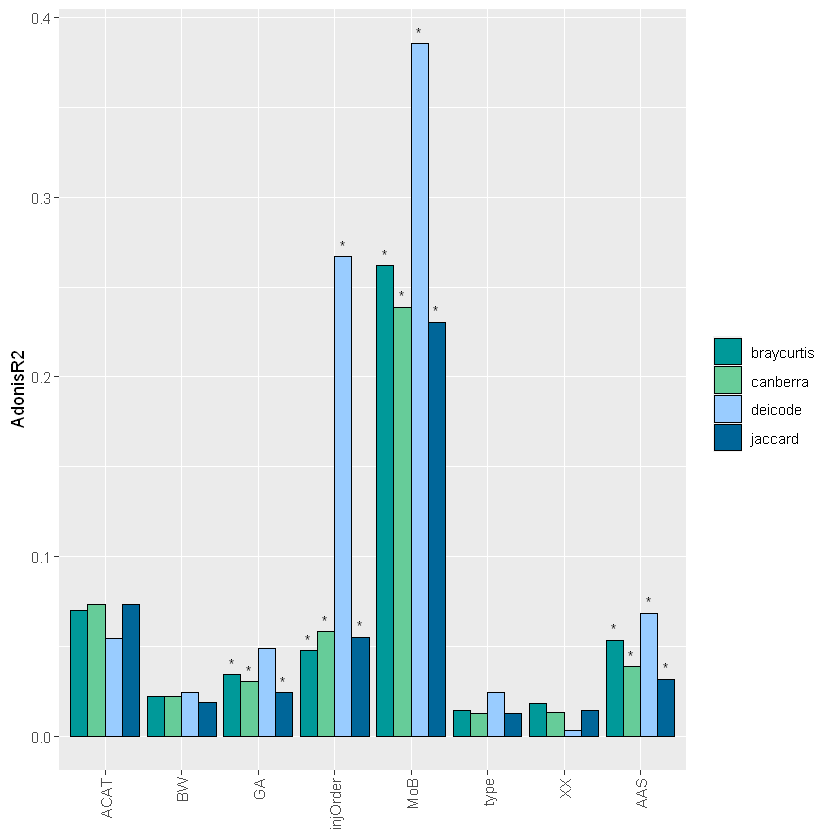

In [42]:
ggplot(out, aes(x=metadata, y=AdonisR2, fill=metric)) + 
geom_bar(colour="black", stat="identity", position='dodge') +
geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
ggpubr::rotate_x_text() +
theme(axis.title.x=element_blank(), legend.title = element_blank()) +
scale_fill_manual(values=cbPalette)

In [43]:
pdf(file="AdonisR2_BARS_colorblind.pdf", width=6, height=6)
    ggplot(out, aes(x=metadata, y=AdonisR2, fill=metric)) + 
    geom_bar(colour="black", stat="identity", position='dodge') +
    geom_text(aes(label=stars), position=position_dodge(width=0.9), vjust=-0.25) +
    ggpubr::rotate_x_text() +
    labs(y= "Adonis R2") +
    theme(axis.title.x=element_blank(), legend.title = element_blank()) +
    scale_fill_manual(values=cbPalette)
dev.off()

png 
  2